# DATAIMPORT/ CLEANUP

In [443]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import numpy as np
import glob
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
from scipy.stats import levene
from itertools import pairwise



In [444]:
file_path = r'C:\Users\cr\Downloads'

df_all = pd.DataFrame()

for version in range(7):
    file_pattern = os.path.join(file_path, f'Version{version}_*.txt')
    files = glob.glob(file_pattern)

    for file in files:
        df = pd.read_csv(file, header=0, names=["ObjInstance", "Identifier", "MethodName", "ElapsedMilliseconds"])
        df['Version'] = f'Version{version}'
        df_all = pd.concat([df_all, df], ignore_index=True)



In [445]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ObjInstance          517 non-null    object
 1   Identifier           517 non-null    object
 2   MethodName           517 non-null    object
 3   ElapsedMilliseconds  517 non-null    int64 
 4   Version              517 non-null    object
dtypes: int64(1), object(4)
memory usage: 20.3+ KB


In [446]:
df_all = df_all.dropna(subset=['ElapsedMilliseconds'])
df_all = df_all.drop_duplicates(subset=["ObjInstance", "Identifier", "MethodName", "ElapsedMilliseconds"])

df_all['ElapsedMilliseconds'] = pd.to_numeric(df_all['ElapsedMilliseconds'], errors='coerce')
df_all = df_all[df_all['ElapsedMilliseconds'] >= 0]

custom_order = [
    "SetParam_OnInit",
    "GenerateOrders",
    "PopulateChartOrderState",
    "OnInit_OnParam",
    "OnParam_OnAfterRender",
    "VisualizeOrderStatusSuccess",
    "FINISH"
]

df_all['MethodName'] = pd.Categorical(df_all['MethodName'], categories=custom_order, ordered=True)
#df_all['Version'] = pd.Categorical(df_all['Version'], categories=custom_order, ordered=True)



## MODIFY DATA

In [447]:
scaler = MinMaxScaler()
df_all['Scaled'] = scaler.fit_transform(df_all[['ElapsedMilliseconds']])
df_all_grouped_median = df_all.groupby(['Version', 'ObjInstance', 'MethodName'], as_index=False)['ElapsedMilliseconds'].median()

C:\Users\cr\AppData\Local\Temp\ipykernel_27928\1371264718.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_all_grouped_median = df_all.groupby(['Version', 'ObjInstance', 'MethodName'], as_index=False)['ElapsedMilliseconds'].median()


# CHECK SIGNIFICANCE

## PLOT

C:\Users\cr\AppData\Local\Temp\ipykernel_27928\4281484521.py:1: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  g = sns.catplot(


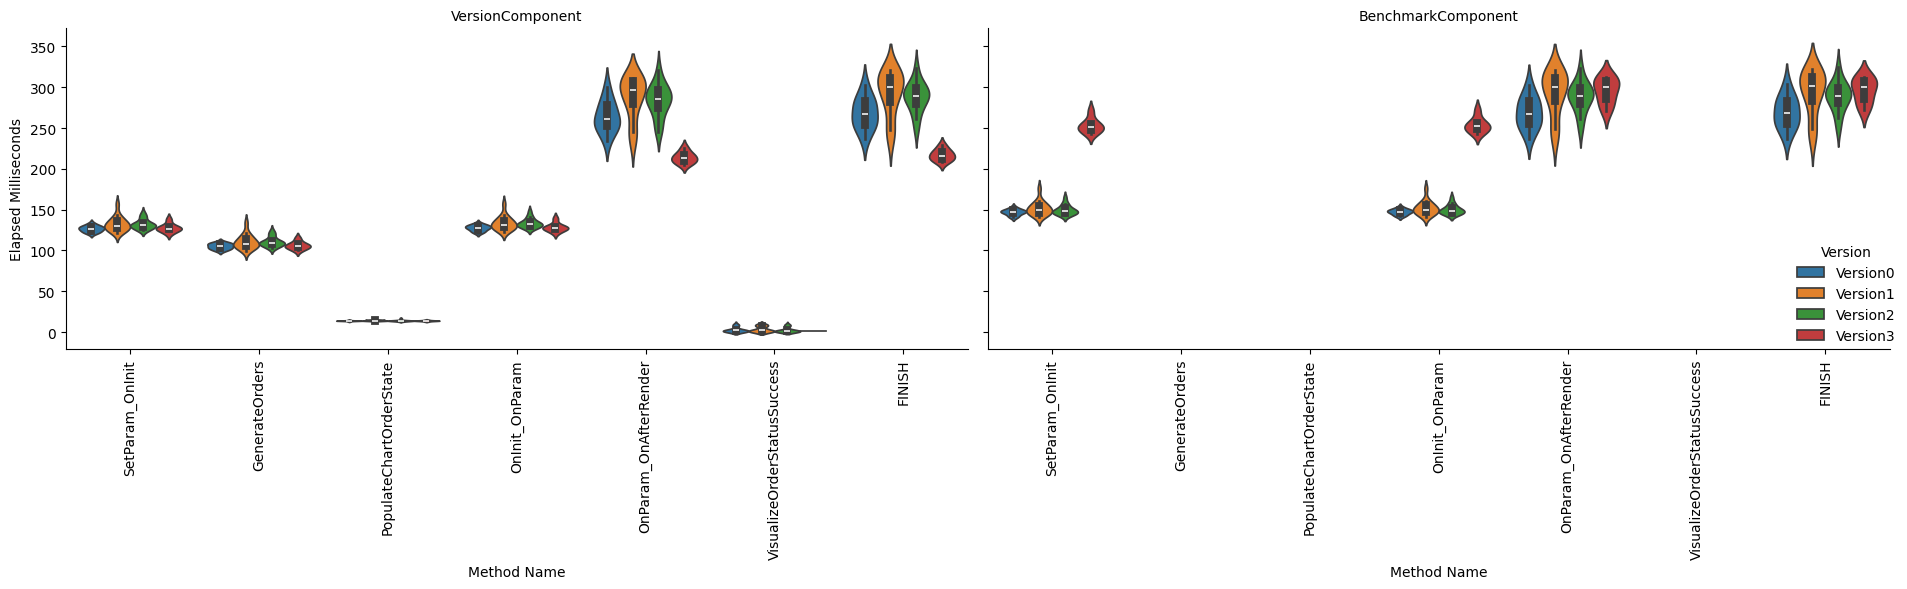

In [448]:
g = sns.catplot(
    data=df_all,
    x="MethodName",
    y="ElapsedMilliseconds",
    hue="Version",
    col="ObjInstance",
    kind="violin",
    scale="width",
    height=6,
    aspect=1.5
)

g.set_axis_labels("Method Name", "Elapsed Milliseconds")
g.set_titles("{col_name}")
g.set_xticklabels(rotation=90)

plt.tight_layout()
plt.show()

## CALCULATION

In [472]:
methods = df_all['MethodName'].unique()

df_version_component = df_all[df_all['ObjInstance'] == 'VersionComponent']


for method in methods:
    method_data = df_version_component[df_version_component['MethodName'] == method]
    versions = method_data['Version'].unique()

    # Erstelle Gruppen für jede Version
    groups = [method_data[method_data['Version'] == version]['ElapsedMilliseconds'] for version in versions]

    # Levene-Test durchführen
    levene_stat, levene_p = levene(*groups)

    # ANOVA durchführen
    f_value, p_value = stats.f_oneway(*groups)

    if levene_p < 0.05:
        print(f"Levene-Test: W = {levene_stat}, p-Wert = {levene_p}")
    
    if p_value < 0.05:
        print(f"ANOVA für {method}: F-Wert = {f_value}, p-Wert = {p_value}")
    


ANOVA für OnParam_OnAfterRender: F-Wert = 22.751244629658522, p-Wert = 5.620930101925011e-09
ANOVA für FINISH: F-Wert = 22.846889426771796, p-Wert = 5.322117389933584e-09


In [ ]:
method_names = df_all['MethodName'].unique()


versions = [f'Version{i}' for i in range(7)]
df_version_component = df_all[df_all['ObjInstance'] == 'VersionComponent']

for method_name in method_names:
    print(f"\nVergleiche für Methode: {method_name}")
    
    df_method = df_version_component[df_version_component['MethodName'] == method_name]
    
    for version_a, version_b in pairwise(versions):
        version_a_data = df_method[df_method['Version'] == version_a]['ElapsedMilliseconds']
        version_b_data = df_method[df_method['Version'] == version_b]['ElapsedMilliseconds']
        
        # Welch's t-Test
        t_stat, p_value = stats.ttest_ind(version_a_data, version_b_data, equal_var=False)
        if p_value < 0.05:
            print(f"{version_b} und {version_a} t-test : t-statistic = {t_stat}, p-value = {p_value}")
        
        # Mann-Whitney U-Test
        u_stat, p_value_u = stats.mannwhitneyu(version_a_data, version_b_data)
        if p_value_u < 0.05:
            print(f"{version_b} und {version_a} U-Test : U-statistic = {u_stat}, p-value = {p_value_u}")



Vergleiche für Methode: GenerateOrders

Vergleiche für Methode: PopulateChartOrderState

Vergleiche für Methode: SetParam_OnInit
Version3 und Version2 t-test : t-statistic = -27.482531372990707, p-value = 1.2935619683914434e-09
Version3 und Version2 U-Test : U-statistic = 0.0, p-value = 0.0002389459524182326

Vergleiche für Methode: OnInit_OnParam
Version3 und Version2 t-test : t-statistic = -26.887214764955804, p-value = 2.363674626339232e-09
Version3 und Version2 U-Test : U-statistic = 0.0, p-value = 0.0002409014790990387

Vergleiche für Methode: OnParam_OnAfterRender
Version1 und Version0 t-test : t-statistic = -2.544823968815541, p-value = 0.018155773766166543
Version1 und Version0 U-Test : U-statistic = 36.0, p-value = 0.03264538972505971

Vergleiche für Methode: VisualizeOrderStatusSuccess

Vergleiche für Methode: FINISH
Version1 und Version0 t-test : t-statistic = -2.5025467699854027, p-value = 0.019939351360258217
Version1 und Version0 U-Test : U-statistic = 36.5, p-value = 0.

C:\Users\cr\AppData\Local\Temp\ipykernel_27928\533981198.py:17: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_ind(version_a_data, version_b_data, equal_var=False)
C:\Users\cr\AppData\Local\Temp\ipykernel_27928\533981198.py:22: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  u_stat, p_value_u = stats.mannwhitneyu(version_a_data, version_b_data)


# DATA EXPLORATION

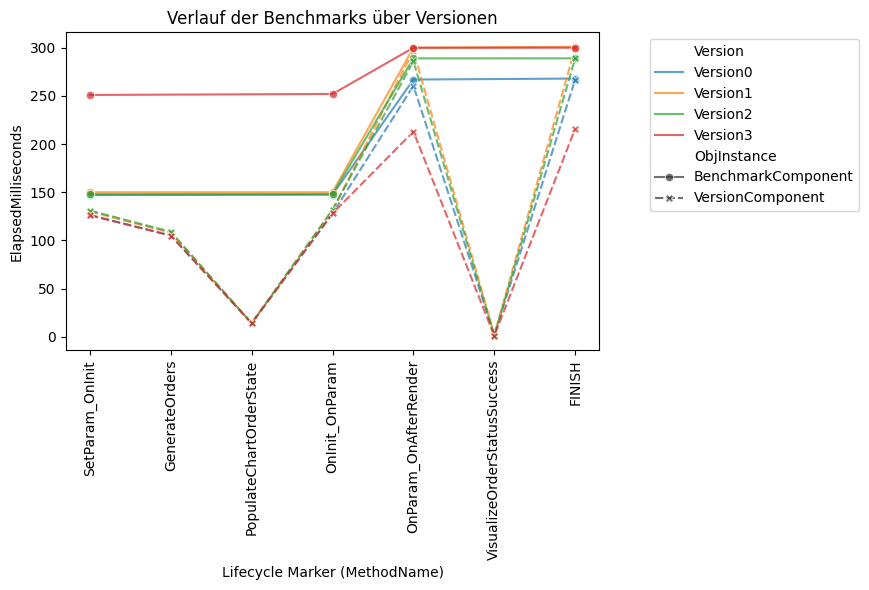

In [451]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_all_grouped_median, 
             x='MethodName',
               y='ElapsedMilliseconds', 
               hue='Version', 
               style='ObjInstance',
              
             alpha=0.7,
               markers=True)

# Beschriftungen und Titel
plt.title('Verlauf der Benchmarks über Versionen')
plt.xlabel('Lifecycle Marker (MethodName)')
plt.ylabel('ElapsedMilliseconds')
plt.xticks(rotation=90)

# Zeige das Diagramm
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.tight_layout()
plt.show()


C:\Users\cr\AppData\Local\Temp\ipykernel_27928\1059196240.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivot = df_all.pivot_table(
C:\Users\cr\AppData\Local\Temp\ipykernel_27928\1059196240.py:1: FutureWarning: The provided callable <function median at 0x000001694BC149A0> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df_pivot = df_all.pivot_table(


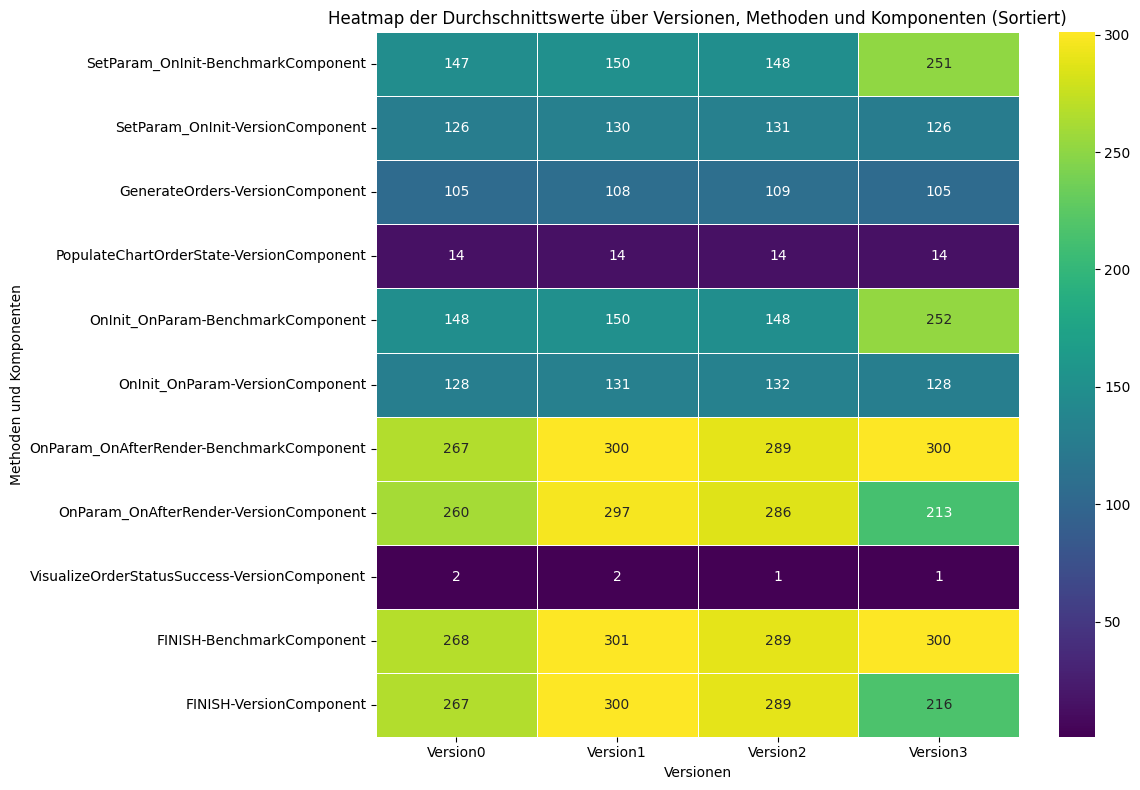

In [452]:
df_pivot = df_all.pivot_table(
    values='ElapsedMilliseconds',
    index=['MethodName', 'ObjInstance'],
    columns='Version',
    aggfunc=np.median
).sort_index(level=0)

plt.figure(figsize=(12, 8))
sns.heatmap(df_pivot, annot=True, fmt='.0f', cmap='viridis', linewidths=0.5)

plt.title('Heatmap der Durchschnittswerte über Versionen, Methoden und Komponenten (Sortiert)')
plt.xlabel('Versionen')
plt.ylabel('Methoden und Komponenten')

plt.tight_layout()
plt.show()


C:\Users\cr\AppData\Local\Temp\ipykernel_27928\2674607206.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivot = df_all.pivot_table(
C:\Users\cr\AppData\Local\Temp\ipykernel_27928\2674607206.py:1: FutureWarning: The provided callable <function median at 0x000001694BC149A0> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df_pivot = df_all.pivot_table(


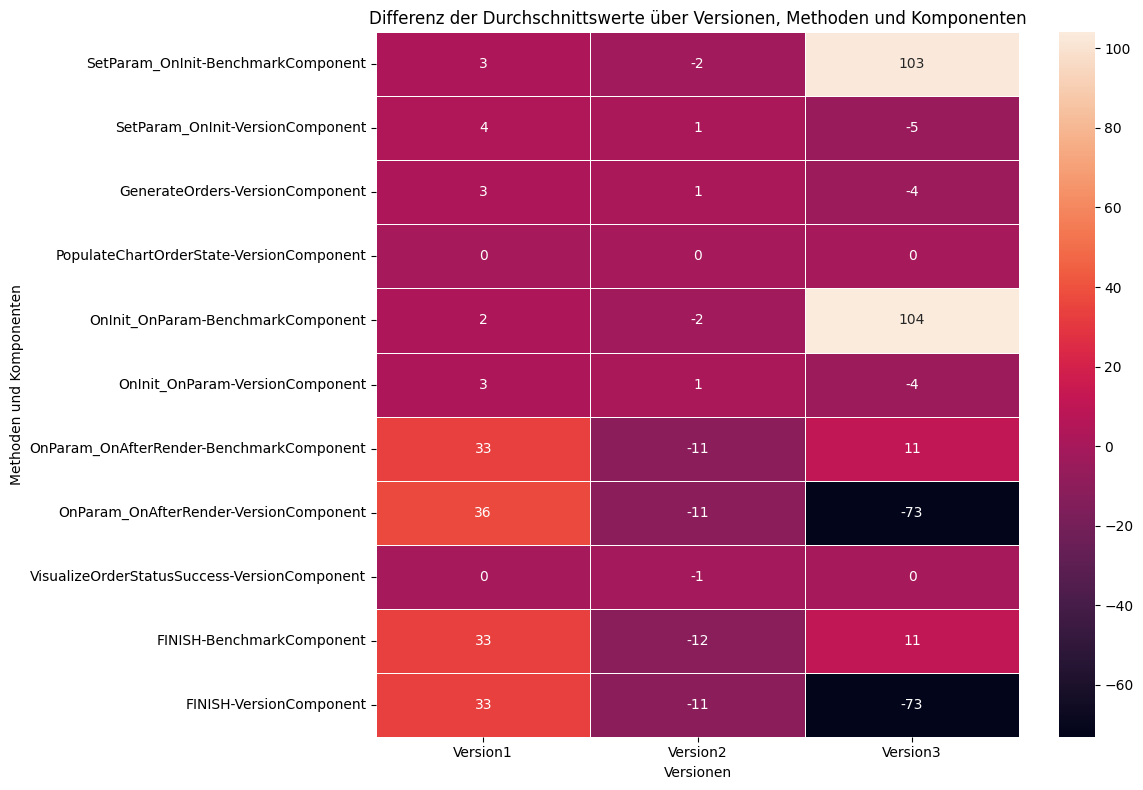

In [453]:
df_pivot = df_all.pivot_table(
    values='ElapsedMilliseconds',
    index=['MethodName', 'ObjInstance'],
    columns='Version',
    aggfunc=np.median
).sort_index(level=0)

df_diff = df_pivot.diff(axis=1).iloc[:, 1:]

plt.figure(figsize=(12, 8))
sns.heatmap(df_diff, annot=True, fmt='.0f', linewidths=0.5)

plt.title('Differenz der Durchschnittswerte über Versionen, Methoden und Komponenten')
plt.xlabel('Versionen')
plt.ylabel('Methoden und Komponenten')

plt.tight_layout()
plt.show()
